# Bayesian Neural Networks

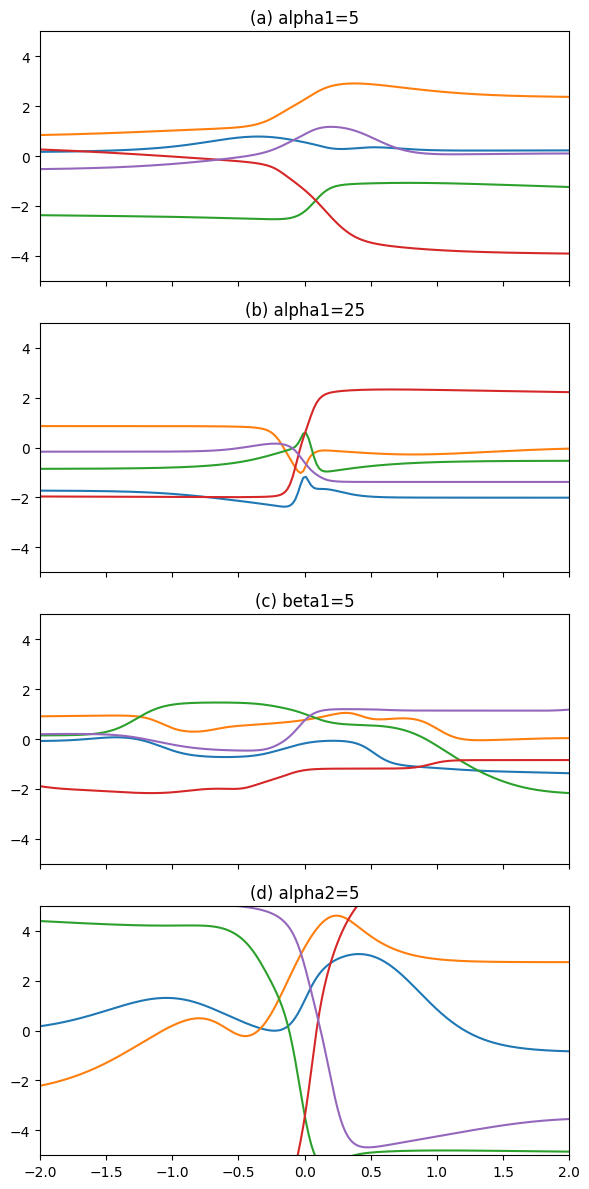

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def mlp_prior_sample(x, n_hidden, alpha1, beta1, alpha2, beta2, n_samples=5):
    """
    Samples functions from an MLP prior.
    
    Args:
        x: Input array of shape (n_points, 1)
        n_hidden: Number of hidden units
        alpha1: Std dev of input weights (W1)
        beta1: Std dev of hidden biases (b1)
        alpha2: Std dev of output weights (W2)
        beta2: Std dev of output biases (b2)
        n_samples: Number of function samples to draw
        
    Returns:
        Y: Output array of shape (n_points, n_samples)
    """
    n_points = x.shape[0]
    Y = np.zeros((n_points, n_samples))
    
    for i in range(n_samples):
        # Sample parameters from Gaussian priors
        # W1: Input -> Hidden
        W1 = np.random.normal(0, alpha1, size=(1, n_hidden))
        # b1: Hidden Bias
        b1 = np.random.normal(0, beta1, size=(1, n_hidden))
        # W2: Hidden -> Output
        # Note: Often scaled by 1/sqrt(n_hidden) in some implementations, 
        # but based on the caption description, we treat alpha2 as the raw scale.
        W2 = np.random.normal(0, alpha2, size=(n_hidden, 1))
        # b2: Output Bias
        b2 = np.random.normal(0, beta2, size=(1, 1))
        
        # Forward pass: y = W2 * tanh(W1*x + b1) + b2
        # x is (n_points, 1), W1 is (1, n_hidden) -> hidden_pre is (n_points, n_hidden)
        hidden_pre = np.dot(x, W1) + b1
        hidden_act = np.tanh(hidden_pre)
        
        # Output
        y = np.dot(hidden_act, W2) + b2
        Y[:, i] = y.flatten()
        
    return Y

# --- Configuration ---
np.random.seed(42)
x_range = np.linspace(-2, 2, 200).reshape(-1, 1)
n_hidden = 12  # Number of hidden units
n_samples = 5  # Samples per plot

# Hyperparameter configurations based on caption
# (a) Baseline
config_a = {'alpha1': 5, 'beta1': 1, 'alpha2': 1, 'beta2': 1, 'title': '(a) alpha1=5'}
# (b) Increase alpha1 by factor of 5
config_b = {'alpha1': 25, 'beta1': 1, 'alpha2': 1, 'beta2': 1, 'title': '(b) alpha1=25'}
# (c) Increase beta1 by factor of 5
config_c = {'alpha1': 5, 'beta1': 5, 'alpha2': 1, 'beta2': 1, 'title': '(c) beta1=5'}
# (d) Increase alpha2 by factor of 5
config_d = {'alpha1': 5, 'beta1': 1, 'alpha2': 5, 'beta2': 1, 'title': '(d) alpha2=5'}

configs = [config_a, config_b, config_c, config_d]

# --- Plotting ---
fig, axes = plt.subplots(4, 1, figsize=(6, 12), sharex=True)
axes = axes.flatten()

for i, conf in enumerate(configs):
    ax = axes[i]
    
    # Generate samples
    # Note: Standardizing normalization 1/sqrt(H) is sometimes implicit 
    # in alpha2 for these plots, but raw std dev aligns with the visual "factor of 5" increase.
    # To match Murphy's specific plot visuals, we normalize the output W2 by sqrt(n_hidden)
    # to keep baseline variance reasonable, then apply the alpha2 scaling.
    scaled_alpha2 = conf['alpha2'] / np.sqrt(n_hidden)
    
    Y = mlp_prior_sample(x_range, n_hidden, 
                         conf['alpha1'], conf['beta1'], 
                         scaled_alpha2, conf['beta2'], 
                         n_samples)
    
    # Plot samples
    for s in range(n_samples):
        ax.plot(x_range, Y[:, s], linewidth=1.5)
        
    ax.set_title(conf['title'])
    ax.set_ylim(-5, 5) # Fix y-axis to make amplitude changes (d) obvious
    ax.set_xlim(-2, 2)
    
plt.tight_layout()
plt.show()

## Comparison between inference methods for BNNs

C:\Users\danie\AppData\Local\Temp\ipykernel_35656\2322123911.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sin(x) * 0.5 * x


1. Running Deep Ensembles...
2. Running SWAG...
3. Running Laplace...
4. Running VI (Mean Field)...
5. Running HMC...
    Step 0: Acceptance Rate 0.00
    Step 100: Acceptance Rate 0.01
   HMC Finished. Total Accepted: 6/150


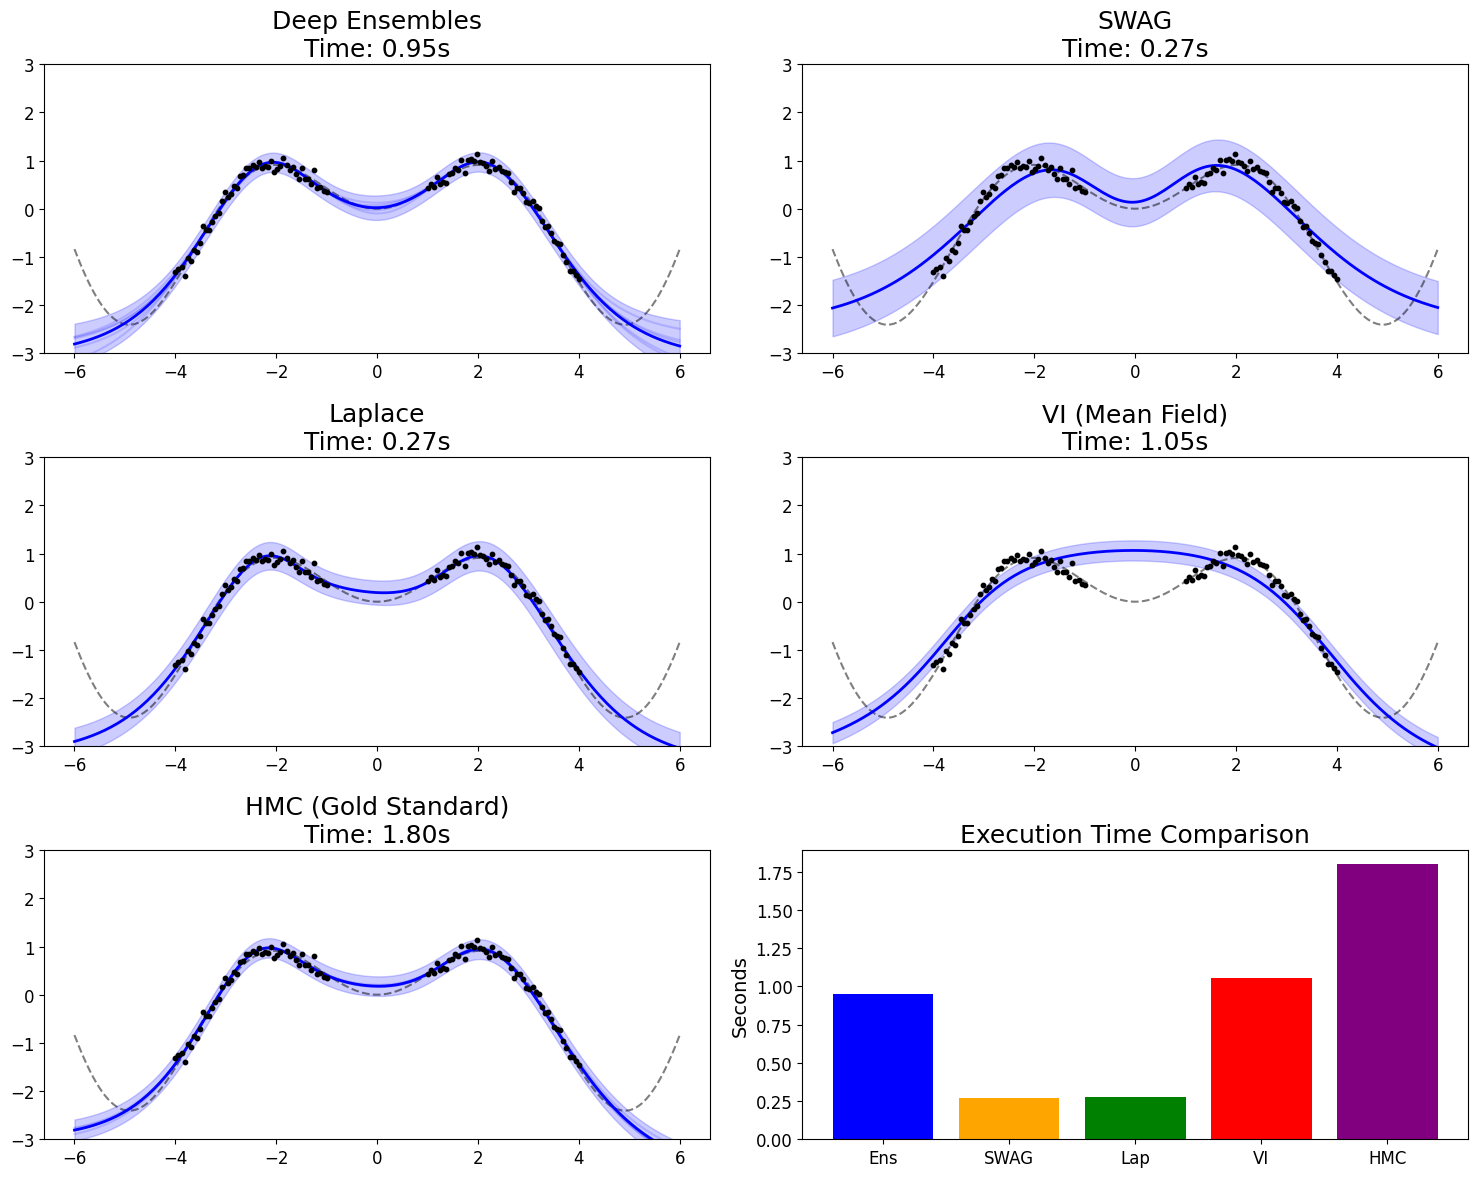

In [8]:
import os
# --- 1. CRASH FIX: MUST BE FIRST ---
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
from torch.nn.utils import parameters_to_vector, vector_to_parameters

# ==========================================
# 2. DATA GENERATION
# ==========================================
torch.manual_seed(42)
np.random.seed(42)

def true_function(x):
    return np.sin(x) * 0.5 * x

# Generate data with a "Gap" [-1, 1]
N_SAMPLES = 100
NOISE_SIGMA = 0.1

X_train = torch.cat([
    torch.linspace(-4, -1, N_SAMPLES // 2),
    torch.linspace(1, 4, N_SAMPLES // 2)
]).view(-1, 1)

y_train = true_function(X_train) + torch.randn_like(X_train) * NOISE_SIGMA

X_test = torch.linspace(-6, 6, 200).view(-1, 1)
y_test_true = true_function(X_test)

# Standard Model Architecture
class MLP(nn.Module):
    def __init__(self, hidden_dim=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

# ==========================================
# METHOD 1: DEEP ENSEMBLES
# ==========================================
print("1. Running Deep Ensembles...")
t0 = time.time()
ensemble_preds = []
for i in range(5):
    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(250):
        optimizer.zero_grad()
        loss = nn.MSELoss()(model(X_train), y_train)
        loss.backward()
        optimizer.step()
    ensemble_preds.append(model(X_test).detach().numpy())

ensemble_preds = np.array(ensemble_preds)
# Flatten ensures 1D array for plotting
mean_ens = ensemble_preds.mean(axis=0).flatten()
std_ens = np.sqrt(ensemble_preds.var(axis=0).flatten() + NOISE_SIGMA**2)
time_ens = time.time() - t0

# ==========================================
# METHOD 2: SWAG
# ==========================================
print("2. Running SWAG...")
t0 = time.time()
swag_model = MLP()
optimizer = optim.SGD(swag_model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()

w_avg = {name: torch.zeros_like(param) for name, param in swag_model.named_parameters()}
w_sq_avg = {name: torch.zeros_like(param) for name, param in swag_model.named_parameters()}
n_models = 0

for epoch in range(400):
    optimizer.zero_grad()
    loss = criterion(swag_model(X_train), y_train)
    loss.backward()
    optimizer.step()
    
    if epoch > 200: # Collect moments
        with torch.no_grad():
            for name, param in swag_model.named_parameters():
                w_avg[name] = (n_models * w_avg[name] + param) / (n_models + 1)
                w_sq_avg[name] = (n_models * w_sq_avg[name] + param ** 2) / (n_models + 1)
            n_models += 1

swag_preds = []
with torch.no_grad():
    for _ in range(30):
        sample_model = copy.deepcopy(swag_model)
        for name, param in sample_model.named_parameters():
            mu = w_avg[name]
            sigma = torch.sqrt(torch.clamp(w_sq_avg[name] - mu**2, min=1e-6))
            param.copy_(mu + sigma * torch.randn_like(mu))
        swag_preds.append(sample_model(X_test).numpy())

swag_preds = np.array(swag_preds)
mean_swag = swag_preds.mean(axis=0).flatten()
std_swag = np.sqrt(swag_preds.var(axis=0).flatten() + NOISE_SIGMA**2)
time_swag = time.time() - t0

# ==========================================
# METHOD 3: LAPLACE APPROXIMATION
# ==========================================
print("3. Running Laplace...")
t0 = time.time()
map_model = MLP()
optimizer = optim.Adam(map_model.parameters(), lr=0.01)
for epoch in range(300):
    optimizer.zero_grad()
    loss = nn.MSELoss()(map_model(X_train), y_train)
    loss.backward()
    optimizer.step()

precision_diag = {k: torch.zeros_like(v) for k, v in map_model.named_parameters()}
map_model.eval()
for x, y in zip(X_train, y_train):
    map_model.zero_grad()
    output = map_model(x.unsqueeze(0))
    loss = 0.5 * (y - output)**2 / NOISE_SIGMA**2
    loss.backward()
    with torch.no_grad():
        for name, param in map_model.named_parameters():
            if param.grad is not None:
                precision_diag[name] += param.grad ** 2 + 1.0 # + Prior

laplace_preds = []
with torch.no_grad():
    for _ in range(30):
        sample_model = copy.deepcopy(map_model)
        for name, param in sample_model.named_parameters():
            mu = param.data
            sigma = 1.0 / torch.sqrt(precision_diag[name])
            param.copy_(mu + sigma * torch.randn_like(mu))
        laplace_preds.append(sample_model(X_test).numpy())

laplace_preds = np.array(laplace_preds)
mean_lap = laplace_preds.mean(axis=0).flatten()
std_lap = np.sqrt(laplace_preds.var(axis=0).flatten() + NOISE_SIGMA**2)
time_lap = time.time() - t0

# ==========================================
# METHOD 4: VI (Mean Field)
# ==========================================
print("4. Running VI (Mean Field)...")
t0 = time.time()
class VILinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w_mu = nn.Parameter(torch.randn(out_features, in_features)*0.1)
        self.w_rho = nn.Parameter(torch.randn(out_features, in_features)-5)
        self.b_mu = nn.Parameter(torch.randn(out_features)*0.1)
        self.b_rho = nn.Parameter(torch.randn(out_features)-5)
    def forward(self, x):
        w = self.w_mu + torch.log1p(torch.exp(self.w_rho)) * torch.randn_like(self.w_mu)
        b = self.b_mu + torch.log1p(torch.exp(self.b_rho)) * torch.randn_like(self.b_mu)
        return torch.nn.functional.linear(x, w, b)

vi_model = nn.Sequential(VILinear(1, 50), nn.Tanh(), VILinear(50, 1))
opt_vi = optim.Adam(vi_model.parameters(), lr=0.01)
for epoch in range(600):
    opt_vi.zero_grad()
    preds = vi_model(X_train)
    nll = 0.5 * torch.mean((preds - y_train)**2) / NOISE_SIGMA**2
    kl = 0.001 * sum(p.norm() for p in vi_model.parameters()) 
    loss = nll + kl
    loss.backward()
    opt_vi.step()

vi_preds = np.array([vi_model(X_test).detach().numpy() for _ in range(50)])
mean_vi = vi_preds.mean(axis=0).flatten()
std_vi = np.sqrt(vi_preds.var(axis=0).flatten() + NOISE_SIGMA**2)
time_vi = time.time() - t0

# ==========================================
# METHOD 5: HAMILTONIAN MONTE CARLO (HMC)
# ==========================================
print("5. Running HMC...")
t0 = time.time()

# HMC Helper Class
class HMC_Sampler:
    def __init__(self, model, X, y, noise_sigma=0.1, prior_std=1.0):
        self.model = model
        self.X = X
        self.y = y
        self.noise_sigma = noise_sigma
        self.prior_std = prior_std

    def potential_energy(self, q_vector):
        vector_to_parameters(q_vector, self.model.parameters())
        preds = self.model(self.X)
        nll = 0.5 * torch.sum((preds - self.y)**2) / (self.noise_sigma**2)
        log_prior = 0.5 * torch.sum(q_vector**2) / (self.prior_std**2)
        return nll + log_prior

    def energy_and_grad(self, q_vector):
        q = q_vector.detach().requires_grad_(True)
        energy = self.potential_energy(q)
        grad = torch.autograd.grad(energy, q)[0]
        return energy.detach(), grad

    def run_sampling(self, n_samples, burn_in, epsilon, L_steps):
        current_q = parameters_to_vector(self.model.parameters()).detach()
        samples = []
        accepted = 0
        
        for i in range(burn_in + n_samples):
            q, p = current_q.clone(), torch.randn_like(current_q)
            current_p = p.clone()
            
            U_start, grad_U = self.energy_and_grad(q)
            H_start = U_start + 0.5 * torch.sum(p**2)
            
            # Leapfrog
            p = p - (epsilon/2) * grad_U
            for _ in range(L_steps):
                q = q + epsilon * p
                if _ != L_steps - 1:
                    _, grad_U = self.energy_and_grad(q)
                    p = p - epsilon * grad_U
            U_end, grad_U = self.energy_and_grad(q)
            p = p - (epsilon/2) * grad_U
            
            H_end = U_end + 0.5 * torch.sum(p**2)
            
            # Metropolis Acceptance
            if (H_start - H_end) > 0 or torch.rand(1) < torch.exp(H_start - H_end):
                current_q = q
                accepted += 1
                if i >= burn_in:
                    samples.append(current_q.clone())
            
            # Debug print occasionally
            if i % 100 == 0:
                print(f"    Step {i}: Acceptance Rate {accepted/(i+1):.2f}")
                    
        print(f"   HMC Finished. Total Accepted: {accepted}/{burn_in+n_samples}")
        return samples

# HMC Execution
hmc_model = MLP()
# 1. Pretrain MAP
opt_hmc = optim.Adam(hmc_model.parameters(), lr=0.01)
for epoch in range(500):
    opt_hmc.zero_grad()
    loss = nn.MSELoss()(hmc_model(X_train), y_train)
    loss.backward()
    opt_hmc.step()

# 2. Sample
sampler = HMC_Sampler(hmc_model, X_train, y_train, noise_sigma=NOISE_SIGMA)

# >>> CRITICAL CHANGE: REDUCED EPSILON FOR STABILITY <<<
# epsilon=0.0005 makes steps smaller so it doesn't "fly off" the curve
posterior_samples = sampler.run_sampling(n_samples=50, burn_in=100, epsilon=0.0005, L_steps=20)

# 3. Predict
hmc_preds = []
with torch.no_grad():
    for w in posterior_samples:
        vector_to_parameters(w, hmc_model.parameters())
        hmc_preds.append(hmc_model(X_test).numpy())
hmc_preds = np.array(hmc_preds)

# --- CRASH FIX LOGIC ---
if len(hmc_preds) > 0:
    mean_hmc = hmc_preds.mean(axis=0).flatten()
    std_hmc = np.sqrt(hmc_preds.var(axis=0).flatten() + NOISE_SIGMA**2)
else:
    print("WARNING: HMC rejected all samples. Plotting zero-line.")
    # Ensure they are 1D arrays of shape (200,) not (200, 1)
    mean_hmc = np.zeros(len(X_test)) 
    std_hmc = np.zeros(len(X_test))

time_hmc = time.time() - t0

# ==========================================
# 6. VISUALIZATION
# ==========================================
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

def plot_method(ax, title, mean, std, time_taken, preds=None):
    ax.scatter(X_train.numpy(), y_train.numpy(), c='k', s=10, zorder=3, label='Data')
    ax.plot(X_test.numpy(), y_test_true.numpy(), 'k--', alpha=0.5, label='True Func')
    
    if preds is not None and len(preds) > 0:
        for p in preds[:15]: 
            ax.plot(X_test.numpy(), p, 'b-', alpha=0.15)
            
    # Ensure mean/std are 1D (extra safety)
    ax.plot(X_test.numpy(), mean, 'b-', linewidth=2, label='Mean')
    ax.fill_between(X_test.flatten(), mean - 2*std, mean + 2*std, color='b', alpha=0.2, label='Uncertainty')
    ax.set_title(f"{title}\nTime: {time_taken:.2f}s")
    ax.set_ylim([-3, 3])

plot_method(axes[0], "Deep Ensembles", mean_ens, std_ens, time_ens, ensemble_preds)
plot_method(axes[1], "SWAG", mean_swag, std_swag, time_swag)
plot_method(axes[2], "Laplace", mean_lap, std_lap, time_lap)
plot_method(axes[3], "VI (Mean Field)", mean_vi, std_vi, time_vi)
plot_method(axes[4], "HMC (Gold Standard)", mean_hmc, std_hmc, time_hmc, hmc_preds)

# Bar Chart
axes[5].bar(['Ens', 'SWAG', 'Lap', 'VI', 'HMC'], [time_ens, time_swag, time_lap, time_vi, time_hmc], 
           color=['blue', 'orange', 'green', 'red', 'purple'])
axes[5].set_title("Execution Time Comparison")
axes[5].set_ylabel("Seconds")

plt.tight_layout()
plt.show()

## 2. Harder Problem: Classification (Two Moons)
Here we evaluate the uncertainty estimation on a non-linear binary classification task. We visualize the **predictive entropy** (uncertainty) in the background. High entropy regions (yellow/green) indicate where the model is uncertain, which should ideally align with the decision boundary and regions far from data.

C:\Users\danie\AppData\Local\Temp\ipykernel_35656\2654624101.py:110: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
C:\Users\danie\AppData\Local\Temp\ipykernel_35656\2654624101.py:111: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.arange(y_min, y_max, h))


Training Ensembles...
Training SWAG (Full Implementation)...
Training Laplace...


C:\Users\danie\AppData\Local\Temp\ipykernel_35656\2654624101.py:310: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  nn.BCEWithLogitsLoss()(map_m(X_train_c[i:i+1]), y_train_c[i:i+1]).backward()


Training VI...
Training HMC...
Calculating Wasserstein Distances vs HMC...
Plotting Qualitative Comparison...


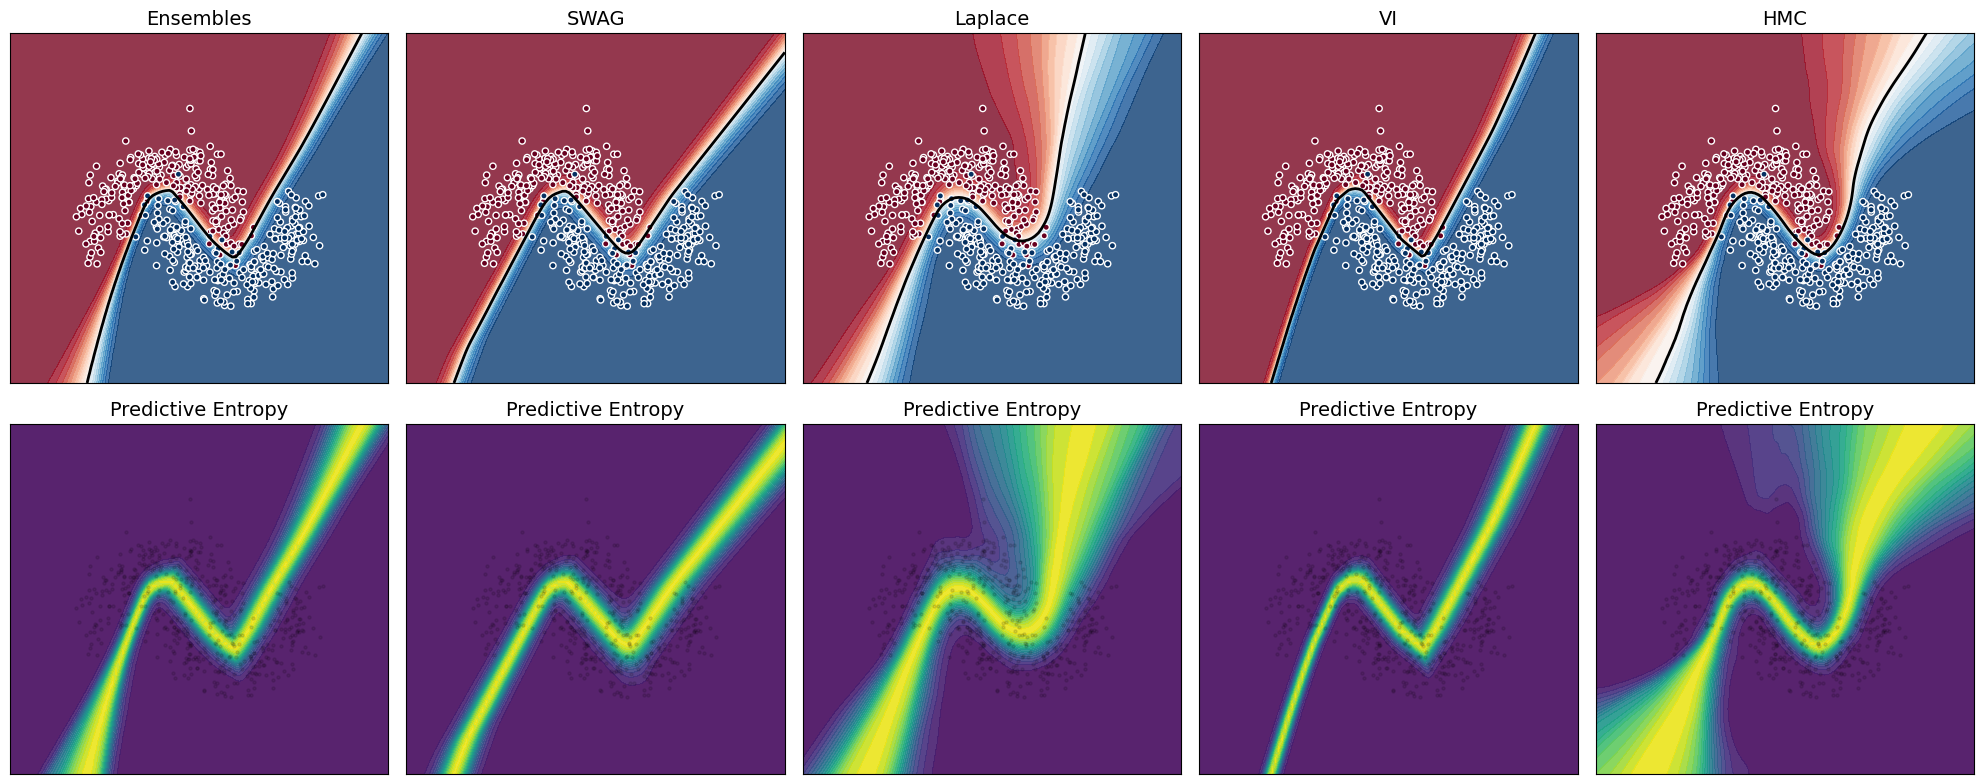

Plotting Quantitative Metrics...


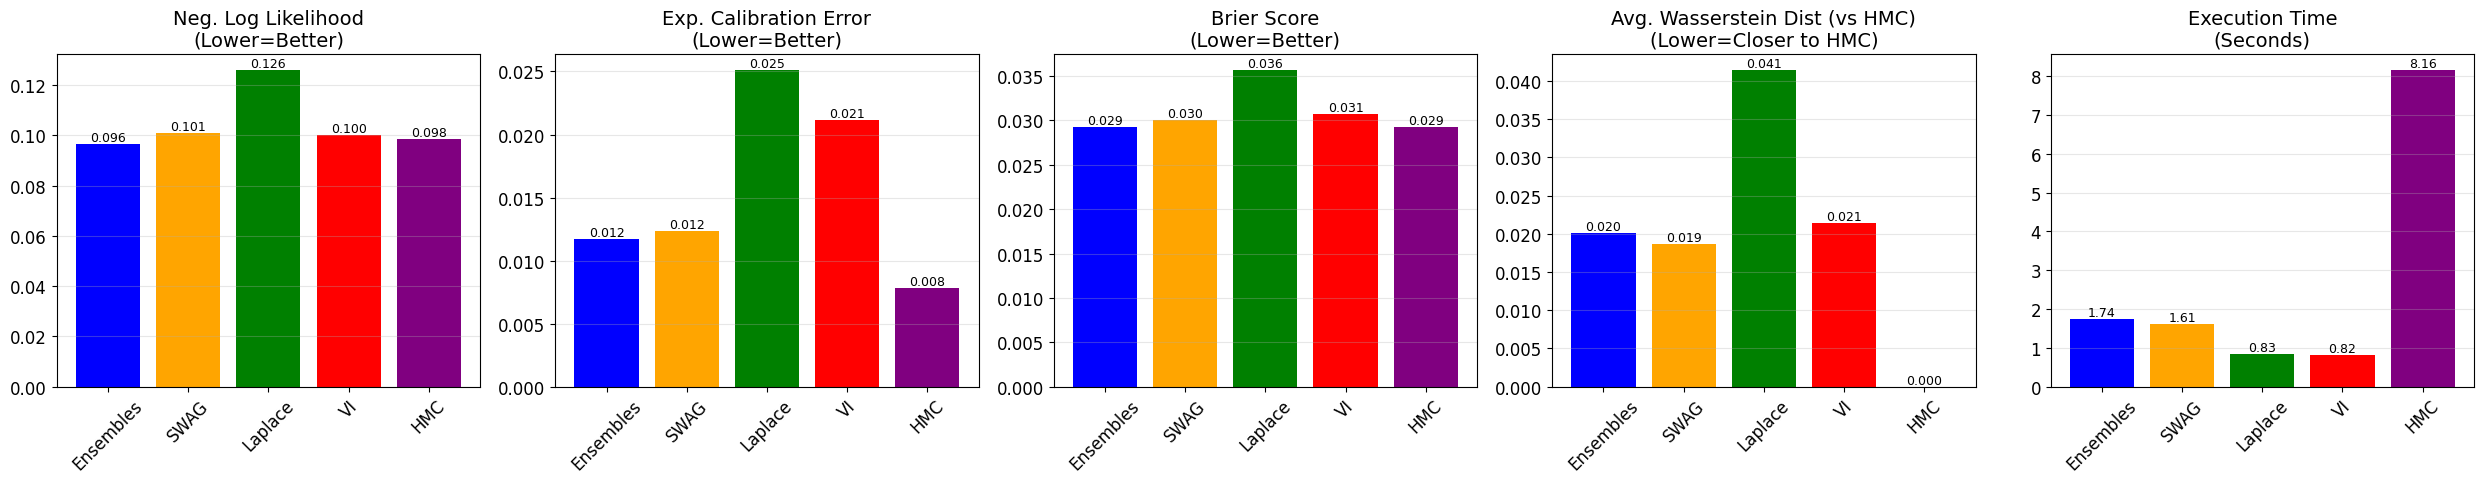

In [19]:
# Dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
from torch.nn.utils import parameters_to_vector, vector_to_parameters

# --- SEEDING for Reproducibility ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- PLOTTING CONFIG ---
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'axes.titlesize': 14})
plt.rcParams.update({'axes.labelsize': 12})

# ==========================================
# 0. METRICS (Proper Scoring Rules & Calibration)
# ==========================================
def nll_calc(probs, targets):
    """Negative Log Likelihood (Proper Scoring Rule) - Lower is Better"""
    p = np.clip(probs, 1e-6, 1-1e-6)
    return -np.mean(targets * np.log(p) + (1-targets) * np.log(1-p))

def brier_calc(probs, targets):
    """Brier Score (Proper Scoring Rule) - Lower is Better"""
    # Mean Squared Error between probability and one-hot target
    return np.mean((probs - targets)**2)

def ece_calc(probs, targets, n_bins=10):
    """Expected Calibration Error - Lower is Better"""
    confs = np.maximum(probs, 1-probs)
    preds = (probs > 0.5).astype(int)
    accs = (preds == targets)
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_mask = (confs > bin_boundaries[i]) & (confs <= bin_boundaries[i+1])
        prop = np.mean(bin_mask)
        if prop > 0:
            avg_acc = np.mean(accs[bin_mask])
            avg_conf = np.mean(confs[bin_mask])
            ece += np.abs(avg_conf - avg_acc) * prop
    return ece

def wasserstein_calc(samples_method, samples_target, n_quantiles=100):
    """
    Average 1D Wasserstein Distance across all test points using Quantile approximation.
    samples_method: (N_samples_1, N_test_points)
    samples_target: (N_samples_2, N_test_points)
    """
    s1 = np.array(samples_method) 
    s2 = np.array(samples_target)
    
    n_test = s1.shape[1]
    w_dists = []
    
    ts = np.linspace(0, 1, n_quantiles)
    for i in range(n_test):
        u = s1[:, i]; v = s2[:, i]
        u_q = np.quantile(u, ts); v_q = np.quantile(v, ts)
        w_dists.append(np.mean(np.abs(u_q - v_q)))
        
    return np.mean(w_dists)

# ==========================================
# 1. DATA GENERATION
# ==========================================
LR = 0.01

def make_moons_custom(n_samples=200, noise=0.2, random_state=42):
    np.random.seed(random_state)
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out
    
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - 0.5
    
    X = np.vstack([np.column_stack([outer_circ_x, outer_circ_y]),
                   np.column_stack([inner_circ_x, inner_circ_y])])
    y = np.hstack([np.zeros(n_samples_out), np.ones(n_samples_in)])
    
    if noise is not None:
        X += np.random.normal(scale=noise, size=X.shape)
    return X, y

# Train / Val / Test
X_train_np, y_train_np = make_moons_custom(n_samples=500, noise=0.2, random_state=42)
X_train_c = torch.tensor(X_train_np, dtype=torch.float32)
y_train_c = torch.tensor(y_train_np, dtype=torch.float32).view(-1, 1)

X_val_np, y_val_np = make_moons_custom(n_samples=100, noise=0.2, random_state=99)
X_val_c = torch.tensor(X_val_np, dtype=torch.float32)
y_val_c = torch.tensor(y_val_np, dtype=torch.float32).view(-1, 1)

X_test_np, y_test_np = make_moons_custom(n_samples=500, noise=0.2, random_state=123)
X_test_c = torch.tensor(X_test_np, dtype=torch.float32)

# Grid
def make_grid(X, pad=1.0, h=0.05):
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    return xx, yy, grid_tensor

xx_c, yy_c, X_grid_c = make_grid(X_train_c)

def entropy(probs):
    p = np.clip(probs, 1e-6, 1-1e-6)
    return -p * np.log(p) - (1-p) * np.log(1-p)

def train_with_early_stopping(model, opt, loss_fn, patience=20, max_epochs=1000, verbose=False):
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0
    for epoch in range(max_epochs):
        model.train()
        opt.zero_grad()
        loss = loss_fn(model(X_train_c), y_train_c)
        loss.backward()
        opt.step()
        
        model.eval()
        with torch.no_grad():
            val_loss = loss_fn(model(X_val_c), y_val_c).item()
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            if verbose: print(f"  Early stopping at epoch {epoch}")
            break
    if best_state: model.load_state_dict(best_state)
    return model

class MLP_Classif(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.net(x)

results = {} 
sample_store = {} 

# ==========================================
# 2. RUNNING METHODS
# ==========================================

# --- A. DEEP ENSEMBLES ---
print(f"Training Ensembles...")
t0 = time.time()
ens_models = []
for i in range(10):
    m = MLP_Classif()
    opt = optim.Adam(m.parameters(), lr=LR)
    train_with_early_stopping(m, opt, nn.BCEWithLogitsLoss(), patience=30, max_epochs=500)
    ens_models.append(m)

ens_probs, ens_test_probs = [], []
with torch.no_grad():
    for m in ens_models: 
        ens_probs.append(torch.sigmoid(m(X_grid_c)).numpy())
        ens_test_probs.append(torch.sigmoid(m(X_test_c)).numpy())

# Store
ens_test_stack = np.array(ens_test_probs) 
mean_grid = np.mean(ens_probs, axis=0).flatten()
mean_test = np.mean(ens_test_stack, axis=0).flatten()

sample_store['Ensembles'] = ens_test_stack
results['Ensembles'] = {
    'grid_mean': mean_grid,
    'nll': nll_calc(mean_test, y_test_np),
    'brier': brier_calc(mean_test, y_test_np),
    'ece': ece_calc(mean_test, y_test_np),
    'time': time.time() - t0
}

# --- B. SWAG (Re-Implemented: Full Low-Rank + Diagonal) ---
print(f"Training SWAG (Full Implementation)...")
t0 = time.time()
swag_m = MLP_Classif()
# 1. Pretraining
opt = optim.SGD(swag_m.parameters(), lr=0.01, momentum=0.9)
train_with_early_stopping(swag_m, opt, nn.BCEWithLogitsLoss(), patience=30, max_epochs=800)

# 2. SWAG Collection
SWAG_LR = 0.04 # High constant LR for exploration
K_RANK = 1    # Number of columns ind Deviation Matrix D
opt.param_groups[0]['lr'] = SWAG_LR

# State containers (flat vectors)
swag_n = 0
theta_swa = torch.zeros_like(parameters_to_vector(swag_m.parameters())) # Mean
theta_sq_swa = torch.zeros_like(theta_swa) # 2nd Moment (Diagonal)
recent_params = [] # List of raw vectors for Low Rank

steps = 300
start_collect = 0
c_cycle = 1 

for epoch in range(steps):
    opt.zero_grad()
    nn.BCEWithLogitsLoss()(swag_m(X_train_c), y_train_c).backward()
    opt.step()
    
    if epoch >= start_collect and (epoch - start_collect) % c_cycle == 0:
        curr = parameters_to_vector(swag_m.parameters()).detach()
        # Update running mean/sq
        theta_swa = (swag_n * theta_swa + curr) / (swag_n + 1)
        theta_sq_swa = (swag_n * theta_sq_swa + curr**2) / (swag_n + 1)
        
        # Store RAW params for D construction later
        if len(recent_params) >= K_RANK: recent_params.pop(0)
        recent_params.append(curr)
        swag_n += 1

# 3. Sampling
swag_probs, swag_test_probs = [], []
sigma_diag = torch.sqrt(torch.clamp(theta_sq_swa - theta_swa**2, min=1e-6))

# Construct D from deviations relative to the FINAL mean
D_col = [p - theta_swa for p in recent_params]

for _ in range(50):
    # Sample z1, z2
    z1 = torch.randn_like(theta_swa)
    z2 = torch.randn(len(D_col)) # vector of size K
    
    # Compute sampled theta
    # theta ~ N(theta_swa, 0.5*Sigma_diag + 0.5*D*D^T/(K-1))
    
    # Diagonal Part: (1/sqrt(2)) * sigma_diag * z1
    samp = theta_swa + (1.0 / np.sqrt(2.0)) * sigma_diag * z1
    
    # Low Rank Part: (1/sqrt(2(K-1))) * D * z2
    if len(D_col) > 1:
        # Stack D columns: shape (P, K)
        D_mat = torch.stack(D_col, dim=1) 
        # Matrix-Vector mult
        D_mult = D_mat @ z2 
        samp += D_mult / np.sqrt(2 * (len(D_col) - 1))
    
    # Load into model and predict
    sample_m = copy.deepcopy(swag_m)
    vector_to_parameters(samp, sample_m.parameters())
    
    with torch.no_grad():
        swag_probs.append(torch.sigmoid(sample_m(X_grid_c)).numpy())
        swag_test_probs.append(torch.sigmoid(sample_m(X_test_c)).numpy())

# Store
swag_test_stack = np.array(swag_test_probs) 
mean_grid = np.mean(swag_probs, axis=0).flatten()
mean_test = np.mean(swag_test_stack, axis=0).flatten()

sample_store['SWAG'] = swag_test_stack
results['SWAG'] = {
    'grid_mean': mean_grid,
    'nll': nll_calc(mean_test, y_test_np),
    'brier': brier_calc(mean_test, y_test_np),
    'ece': ece_calc(mean_test, y_test_np),
    'time': time.time() - t0
}

# --- C. LAPLACE ---
print(f"Training Laplace...")
t0 = time.time()
map_m = MLP_Classif()
opt = optim.Adam(map_m.parameters(), lr=LR)
train_with_early_stopping(map_m, opt, nn.BCEWithLogitsLoss(), patience=50, max_epochs=500)

kfac_A, kfac_G = {}, {}
def save_A(name):
    def hook(model, input, output):
        x = input[0].detach()
        x = torch.cat([x, torch.ones(x.size(0), 1, device=x.device)], dim=1) 
        if name not in kfac_A: kfac_A[name] = torch.zeros(x.shape[1], x.shape[1])
        kfac_A[name] += x.T @ x
    return hook
def save_G(name):
    def hook(model, grad_input, grad_output):
        g = grad_output[0].detach()
        if name not in kfac_G: kfac_G[name] = torch.zeros(g.shape[1], g.shape[1])
        kfac_G[name] += g.T @ g
    return hook
hooks = []
for name, m in map_m.named_modules():
    if isinstance(m, nn.Linear):
        hooks.append(m.register_forward_hook(save_A(name)))
        hooks.append(m.register_full_backward_hook(save_G(name)))
map_m.eval()
for i in range(len(X_train_c)):
    map_m.zero_grad()
    nn.BCEWithLogitsLoss()(map_m(X_train_c[i:i+1]), y_train_c[i:i+1]).backward()
for h in hooks: h.remove()

lap_probs, lap_test_probs = [], []
N_data = len(X_train_c)
prior_prec = 1.0; sqrt_prior = np.sqrt(prior_prec)
for _ in range(50):
    sample_m = copy.deepcopy(map_m)
    with torch.no_grad():
        for name, m in sample_m.named_modules():
            if isinstance(m, nn.Linear) and name in kfac_A:
                A, G = kfac_A[name] / np.sqrt(N_data), kfac_G[name] / np.sqrt(N_data)
                pi = torch.sqrt(torch.trace(A) / torch.trace(G))
                L_A = torch.linalg.cholesky(A + sqrt_prior * pi * torch.eye(A.shape[0]))
                L_G = torch.linalg.cholesky(G + sqrt_prior / pi * torch.eye(G.shape[0]))
                inv_L_A = torch.linalg.inv(L_A); inv_L_G = torch.linalg.inv(L_G)
                Z = torch.randn(G.shape[0], A.shape[0])
                delta = inv_L_G.T @ Z @ inv_L_A 
                m.weight.add_(delta[:, :-1]); m.bias.add_(delta[:, -1])
        lap_probs.append(torch.sigmoid(sample_m(X_grid_c)).numpy())
        lap_test_probs.append(torch.sigmoid(sample_m(X_test_c)).numpy())

# Store
lap_test_stack = np.array(lap_test_probs)
mean_grid = np.mean(lap_probs, axis=0).flatten()
mean_test = np.mean(lap_test_stack, axis=0).flatten()

sample_store['Laplace'] = lap_test_stack
results['Laplace'] = {
    'grid_mean': mean_grid,
    'nll': nll_calc(mean_test, y_test_np),
    'brier': brier_calc(mean_test, y_test_np),
    'ece': ece_calc(mean_test, y_test_np),
    'time': time.time() - t0
}

# --- D. VI ---
print(f"Training VI...")
t0 = time.time()
class VILinear_C(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.w_mu = nn.Parameter(torch.randn(out_f, in_f)*0.1)
        self.w_rho = nn.Parameter(torch.randn(out_f, in_f)-5)
        self.b_mu = nn.Parameter(torch.randn(out_f)*0.1)
        self.b_rho = nn.Parameter(torch.randn(out_f)-5)
    def forward(self, x):
        w = self.w_mu + torch.log1p(torch.exp(self.w_rho)) * torch.randn_like(self.w_mu)
        b = self.b_mu + torch.log1p(torch.exp(self.b_rho)) * torch.randn_like(self.b_mu)
        return torch.nn.functional.linear(x, w, b)
    def kl(self):
        w_sig = torch.log1p(torch.exp(self.w_rho))
        b_sig = torch.log1p(torch.exp(self.b_rho))
        return torch.sum(0.5*(self.w_mu**2 + w_sig**2 - 2*torch.log(w_sig)-1)) + \
               torch.sum(0.5*(self.b_mu**2 + b_sig**2 - 2*torch.log(b_sig)-1))
class VI_Net_C(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = VILinear_C(2, 32); self.l2 = VILinear_C(32, 32); self.l3 = VILinear_C(32, 1)
        self.act = nn.ReLU()
    def forward(self, x): return self.l3(self.act(self.l2(self.act(self.l1(x)))))
    def kl(self): return self.l1.kl() + self.l2.kl() + self.l3.kl()

vi_m = VI_Net_C()
opt = optim.Adam(vi_m.parameters(), lr=LR)
kl_w = 0.1 / len(X_train_c)
best_val_loss = float('inf'); best_state = None; patience=20; patience_counter=0
for epoch in range(500):
    opt.zero_grad()
    loss = nn.BCEWithLogitsLoss(reduction='sum')(vi_m(X_train_c), y_train_c) + vi_m.kl() * kl_w
    loss.backward()
    opt.step()
    with torch.no_grad(): val_loss = nn.BCEWithLogitsLoss(reduction='sum')(vi_m(X_val_c), y_val_c).item()
    if val_loss < best_val_loss:
        best_val_loss = val_loss; best_state = copy.deepcopy(vi_m.state_dict()); patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience: break
if best_state: vi_m.load_state_dict(best_state)

vi_probs, vi_test_probs = [], []
with torch.no_grad():
    for _ in range(50): 
        vi_probs.append(torch.sigmoid(vi_m(X_grid_c)).numpy())
        vi_test_probs.append(torch.sigmoid(vi_m(X_test_c)).numpy())

# Store
vi_test_stack = np.array(vi_test_probs)
mean_grid = np.mean(vi_probs, axis=0).flatten()
mean_test = np.mean(vi_test_stack, axis=0).flatten()

sample_store['VI'] = vi_test_stack
results['VI'] = {
    'grid_mean': mean_grid,
    'nll': nll_calc(mean_test, y_test_np),
    'brier': brier_calc(mean_test, y_test_np),
    'ece': ece_calc(mean_test, y_test_np),
    'time': time.time() - t0
}

# --- E. HMC ---
print(f"Training HMC...")
t0 = time.time()
PRIOR_VAR = 1.0
def hmc_pot(m, x, y):
    nll = nn.BCEWithLogitsLoss(reduction='sum')(m(x), y)
    log_prior = 0.5 * sum(torch.sum(p**2) for p in m.parameters()) / PRIOR_VAR
    return nll + log_prior
def hmc_step_inner(curr, m, x, y, eps=0.002, L=20):
    q = curr.clone().detach().requires_grad_(True)
    vector_to_parameters(q, m.parameters())
    p = torch.randn_like(q); cur_p = p.clone()
    U = hmc_pot(m, x, y); g = parameters_to_vector(torch.autograd.grad(U, m.parameters()))
    p = p - eps * g/2
    for i in range(L):
        q = q + eps * p; vector_to_parameters(q, m.parameters())
        if i!=L-1: U_loop = hmc_pot(m, x, y); g_loop = parameters_to_vector(torch.autograd.grad(U_loop, m.parameters())); p = p - eps * g_loop
    U_new = hmc_pot(m, x, y); g_new = parameters_to_vector(torch.autograd.grad(U_new, m.parameters()))
    p = p - eps * g_new/2; p = -p
    vector_to_parameters(curr, m.parameters())
    cur_H = hmc_pot(m, x, y) + 0.5*torch.sum(cur_p**2)
    prop_H = U_new + 0.5*torch.sum(p**2)
    if torch.rand(1) < torch.exp(cur_H - prop_H): return q.detach(), True
    return curr, False

hmc_m = MLP_Classif()
opt = optim.Adam(hmc_m.parameters(), lr=LR)
train_with_early_stopping(hmc_m, opt, nn.BCEWithLogitsLoss(), patience=50, max_epochs=500)
curr = parameters_to_vector(hmc_m.parameters()).detach()
hmc_samples = []; accepts = 0
for _ in range(100): curr, _ = hmc_step_inner(curr, hmc_m, X_train_c, y_train_c, eps=0.005, L=30) # Burn-in
for _ in range(100):
    curr, acc = hmc_step_inner(curr, hmc_m, X_train_c, y_train_c, eps=0.005, L=30)
    if acc: accepts += 1
    hmc_samples.append(curr.clone())

hmc_probs, hmc_test_probs = [], []
with torch.no_grad():
    for s in hmc_samples:
        vector_to_parameters(s, hmc_m.parameters())
        hmc_probs.append(torch.sigmoid(hmc_m(X_grid_c)).numpy())
        hmc_test_probs.append(torch.sigmoid(hmc_m(X_test_c)).numpy())

# Store
hmc_test_stack = np.array(hmc_test_probs)
mean_grid = np.mean(hmc_probs, axis=0).flatten()
mean_test = np.mean(hmc_test_stack, axis=0).flatten()

sample_store['HMC'] = hmc_test_stack
results['HMC'] = {
    'grid_mean': mean_grid,
    'nll': nll_calc(mean_test, y_test_np),
    'brier': brier_calc(mean_test, y_test_np),
    'ece': ece_calc(mean_test, y_test_np),
    'time': time.time() - t0
}

# ==========================================
# 3. WASSERSTEIN CALCULATION
# ==========================================
print("Calculating Wasserstein Distances vs HMC...")
hmc_samples_target = sample_store['HMC']

for method in ['Ensembles', 'SWAG', 'Laplace', 'VI', 'HMC']:
    # Distance of method M samples to HMC samples
    w_dist = wasserstein_calc(sample_store[method], hmc_samples_target)
    results[method]['wasserstein'] = w_dist

# ==========================================
# 4. VISUALIZATION
# ==========================================
# Figure 1: Qualitative Comparison (Decision Boundary & Entropy)
print("Plotting Qualitative Comparison...")
methods = ['Ensembles', 'SWAG', 'Laplace', 'VI', 'HMC']
fig1, axs1 = plt.subplots(2, 5, figsize=(20, 8))

for i, method in enumerate(methods):
    res = results[method]
    mean_prob = res['grid_mean'].reshape(xx_c.shape)
    ent = entropy(res['grid_mean']).reshape(xx_c.shape)
    time_taken = res['time']
    
    # Row 1: Decision Boundary (Prob)
    ax1 = axs1[0, i]
    ax1.contourf(xx_c, yy_c, mean_prob, levels=20, cmap='RdBu', alpha=0.8)
    ax1.contour(xx_c, yy_c, mean_prob, levels=[0.5], colors='k', linewidths=2)
    ax1.scatter(X_train_c[:,0], X_train_c[:,1], c=y_train_c.flatten(), cmap='RdBu', edgecolors='white', s=20)
    ax1.set_title(f"{method}")
    ax1.set_xticks([]); ax1.set_yticks([])
    
    # Row 2: Uncertainty (Entropy)
    ax2 = axs1[1, i]
    ax2.contourf(xx_c, yy_c, ent, levels=20, cmap='viridis', alpha=0.9)
    ax2.scatter(X_train_c[:,0], X_train_c[:,1], c='k', s=5, alpha=0.1)
    ax2.set_title(f"Predictive Entropy")
    ax2.set_xticks([]); ax2.set_yticks([])

plt.tight_layout()
plt.show()

# Figure 2: Quantitative Metrics (Single Row)
print("Plotting Quantitative Metrics...")
fig2, axs2 = plt.subplots(1, 5, figsize=(25, 5))

# Helper for Bar Plots
def plot_bar(ax, key, title, decimals=3):
    vals = [results[m][key] for m in methods]
    bars = ax.bar(methods, vals, color=['blue', 'orange', 'green', 'red', 'purple'])
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.{decimals}f}', ha='center', va='bottom', fontsize=9)

plot_bar(axs2[0], 'nll', "Neg. Log Likelihood\n(Lower=Better)")
plot_bar(axs2[1], 'ece', "Exp. Calibration Error\n(Lower=Better)")
plot_bar(axs2[2], 'brier', "Brier Score\n(Lower=Better)")
plot_bar(axs2[3], 'wasserstein', "Avg. Wasserstein Dist (vs HMC)\n(Lower=Closer to HMC)")
plot_bar(axs2[4], 'time', "Execution Time\n(Seconds)", decimals=2)

plt.tight_layout()
plt.show()